原文代码作者：https://github.com/wzyonggege/statistical-learning-method

#  第3章 k近邻法

$y = \mathop{argmax} \limits_{c_{j}}\displaystyle \sum_{x_{i} \in N_{k}(x) }I(y_{i}=c_{j}),i=1,2,...,N;j=1,2,...,K$

$x_{i},x_{j}$的距离

$L_{p(x_{i},x_{j})}=(\displaystyle \sum_{l=1}^n|x_{i}^{(l)}-x_{j}^{(l)}|^p)^ \frac{1}{p}$

p=1时，曼哈顿距离(Manhattan distance)

p=2时，称为欧式距离(Euclidean distance)

#### 距离度量

In [4]:
import math
import numpy as np
from itertools import combinations

In [15]:
# 课本例3.1
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]
def L(x, y, p=2):
    x = np.array(x)
    result=[]
    for yi in y:
        yi=np.array(yi)
        result=np.append(result,np.sum(np.power(np.abs(x-yi),p)))
    return result
print(L(x1,[x2,x3]))

[16. 18.]


python实现，遍历所有数据点，找出n个距离最近的点的分类情况，少数服从多数

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter

In [17]:
# data
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
data = np.array(df.iloc[:100, [0, 1, -1]])
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2):

        self.n = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X):
        #选出离目标点最近的p个点,选择其中数量最多的label
        def dist(train):
            return np.linalg.norm(X - train, ord=self.p)
        dist_list = list(map(dist,X_train))
        dist_data=pd.DataFrame(pd.concat([pd.Series(dist_list),pd.Series(y_train)],axis=1))
        dist_data.columns=['dist','label']    
        dist_data.sort_values('dist',inplace=True)
        return dist_data.label[:self.p].value_counts().index[0]
    
    def score(self, X_test, y_test):
        right_count = 0
        n = 10
        for X, y in zip(X_test, y_test):
            if y == self.predict(X):
                right_count += 1
        return right_count / len(X_test)

In [19]:
clf = KNN(X_train, y_train)

In [21]:
test_point = [6.0, 3.0]
print('Test Point: {}'.format(clf.predict(test_point)))

Test Point: 1.0


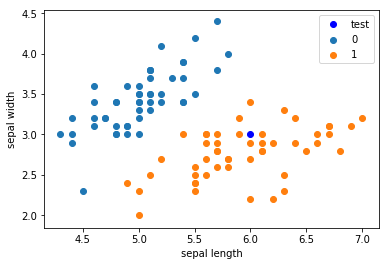

In [23]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

# scikitlearn

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
clf_sk = KNeighborsClassifier()
clf_sk.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [28]:
print(clf.predict([6.0,3.0]))
clf_sk.score(X_test, y_test)

1.0


1.0

### kd树
首先通过二叉树搜索(比较待查询节点和分裂节点的分裂维的值，小于等于就进入左子树分支，等于就进入右子树分支直到叶子结点),顺着“搜索路径”,判断搜索路径上的结点的其他子结点空间中是否可能有距离查询点更近的数据点(到超平面的距离是否小于当前最近临点到目标点的距离)


example:

Reference : https://m.2cto.com/article/201608/538252.html

In [19]:
# kd-tree每个结点中主要包含的数据结构如下 
class KdNode(object):
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt  # k维向量节点(k维空间中的一个样本点)
        self.split = split      # 整数（进行分割维度的序号）
        self.left = left        # 该结点分割超平面左子空间构成的kd-tree
        self.right = right      # 该结点分割超平面右子空间构成的kd-tree
 
 
class KdTree(object):
    def __init__(self, data):
        k = len(data[0])  # 数据维度
        
        def CreateNode(split, data_set): # 按第split维划分数据集exset创建KdNode
            if not data_set:    # 数据集为空
                return None
            # key参数的值为一个函数，此函数只有一个参数且返回一个值用来进行比较
            # operator模块提供的itemgetter函数用于获取对象的哪些维的数据，参数为需要获取的数据在对象中的序号
            #data_set.sort(key=itemgetter(split)) # 按要进行分割的那一维数据排序
            data_set.sort(key=lambda x: x[split])
            split_pos = len(data_set) // 2      # //为Python中的整数除法
            median = data_set[split_pos]        # 中位数分割点             
            split_next = (split + 1) % k        # cycle coordinates
            
            # 递归的创建kd树
            return KdNode(median, split, 
                          CreateNode(split_next, data_set[:split_pos]),     # 创建左子树
                          CreateNode(split_next, data_set[split_pos + 1:])) # 创建右子树
                                
        self.root = CreateNode(0, data)         # 从第0维分量开始构建kd树,返回根节点


# KDTree的前序遍历
def preorder(root):  
    print (root.dom_elt)  
    if root.left:      # 节点不为空
        preorder(root.left)  
    if root.right:  
        preorder(root.right)      

In [20]:
# 对构建好的kd树进行搜索，寻找与目标点最近的样本点：
from math import sqrt
from collections import namedtuple

# 定义一个namedtuple,分别存放最近坐标点、最近距离和访问过的节点数
result = namedtuple("Result_tuple", "nearest_point  nearest_dist  nodes_visited")
  
def find_nearest(tree, point):
    k = len(point) # 数据维度
    def travel(kd_node, target, max_dist):
        if kd_node is None:     
            return result([0] * k, float("inf"), 0) # python中用float("inf")和float("-inf")表示正负无穷
 
        nodes_visited = 1
        
        s = kd_node.split        # 进行分割的维度
        pivot = kd_node.dom_elt  # 进行分割的“轴”
        
        if target[s] <= pivot[s]:           # 如果目标点第s维小于分割轴的对应值(目标离左子树更近)
            nearer_node  = kd_node.left     # 下一个访问节点为左子树根节点
            further_node = kd_node.right    # 同时记录下右子树
        else:                               # 目标离右子树更近
            nearer_node  = kd_node.right    # 下一个访问节点为右子树根节点
            further_node = kd_node.left
 
        temp1 = travel(nearer_node, target, max_dist)  # 进行遍历找到包含目标点的区域
        
        nearest = temp1.nearest_point       # 以此叶结点作为“当前最近点”
        dist = temp1.nearest_dist           # 更新最近距离
        
        nodes_visited += temp1.nodes_visited  
 
        if dist < max_dist:     
            max_dist = dist    # 最近点将在以目标点为球心，max_dist为半径的超球体内
            
        temp_dist = abs(pivot[s] - target[s])    # 第s维上目标点与分割超平面的距离
        if  max_dist < temp_dist:                # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited) # 不相交则可以直接返回，不用继续判断
            
        #----------------------------------------------------------------------  
        # 计算目标点与分割点的欧氏距离  
        temp_dist = sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(pivot, target)))     
        
        if temp_dist < dist:         # 如果“更近”
            nearest = pivot          # 更新最近点
            dist = temp_dist         # 更新最近距离
            max_dist = dist          # 更新超球体半径
        
        # 检查另一个子结点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist) 
        
        nodes_visited += temp2.nodes_visited
        if temp2.nearest_dist < dist:        # 如果另一个子结点内存在更近距离
            nearest = temp2.nearest_point    # 更新最近点
            dist = temp2.nearest_dist        # 更新最近距离
 
        return result(nearest, dist, nodes_visited)
 
    return travel(tree.root, point, float("inf"))  # 从根节点开始递归

### 例3.2

In [21]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [22]:
from time import clock
from random import random

# 产生一个k维随机向量，每维分量值在0~1之间
def random_point(k):
    return [random() for _ in range(k)]
 
# 产生n个k维随机向量 
def random_points(k, n):
    return [random_point(k) for _ in range(n)]     

In [23]:
ret = find_nearest(kd, [3,4.5])
print (ret)

Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [24]:
N = 400000
t0 = clock()
kd2 = KdTree(random_points(3, N))            # 构建包含四十万个3维空间样本点的kd树
ret2 = find_nearest(kd2, [0.1,0.5,0.8])      # 四十万个样本点中寻找离目标最近的点
t1 = clock()
print ("time: ",t1-t0, "s")
print (ret2)

time:  7.299844505209247 s
Result_tuple(nearest_point=[0.10505669630674175, 0.49542598718931097, 0.8033166919543026], nearest_dist=0.007582362181450973, nodes_visited=53)
